mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


importing libraries

In [ ]:
import librosa
import os
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import cv2

Accesing GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
device

device(type='cuda')

Loading Dataset

In [ ]:
csv_file_path='/content/drive/MyDrive/archive (24)/TRAIN.csv'
folder_path_train='/content/drive/MyDrive/archive (24)/TRAIN'


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/archive (24)/TRAIN.csv')

In [ ]:
df

,Filename,Class
0,346.wav,Negative
1,163.wav,Neutral
2,288.wav,Negative
3,279.wav,Negative
4,244.wav,Negative
...,...,...
245,204.wav,Neutral
246,46.wav,Positive
247,318.wav,Negative
248,49.wav,Positive


In [ ]:
#split df into train,test,validation
from sklearn.model_selection import train_test_split
train_df,temp=train_test_split(df,test_size=0.3,random_state=28)
test_df,valid_df=train_test_split(temp,test_size=0.6,random_state=28)

In [ ]:
train_df.shape

(175, 2)

In [ ]:
valid_df.shape

(45, 2)

In [ ]:
test_df.shape

(30, 2)

Class for loading audio files

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
  def __init__(self, folder_path, target_sample_rate,csv_file, resize_dim=(224,224)):
    self.csv_file = csv_file
    self.folder_path = folder_path
    self.sample_rate = target_sample_rate
    self.resize_dim =  resize_dim
    self.mapping = {"Positive": [1, 0, 0], "Neutral": [0, 1, 0], "Negative": [0, 0, 1]}

  def __getitem__(self, idx):
    filename = os.path.join(self.folder_path, self.csv_file.iloc[idx, 0])
    audio_data, sr = librosa.load(filename, sr=self.sample_rate)
    audio_data = librosa.feature.melspectrogram(y=audio_data,sr=target_sample_rate,n_fft=400,hop_length=160,n_mels=15)
    audio_data = cv2.resize(audio_data, self.resize_dim)

    labels = self.csv_file.iloc[idx, 1]
    labels = np.array(self.mapping[labels])

    return audio_data,  labels

  def __len__(self):
    return len(self.csv_file)


In [ ]:
def collate_fn(batch):
  audios = []
  labels = []
  for audio, label in batch:
     audios.append(torch.tensor(audio)) ###
     labels.append(label)

     #padding of audio list
  #audios=pad_sequence(audios, batch_first=True)
  #convert to tensor
  #audios = np.array(audios)
  #audios = torch.from_numpy(audios)
  labels=torch.tensor(labels, dtype=torch.float32)
  # labels=labels.shape
  # return them
  return audios,labels


In [ ]:
target_sample_rate=44100

In [ ]:
train_data=AudioDataset(folder_path_train,44100,train_df)
valid_data=AudioDataset(folder_path_train,44100,valid_df)
test_data=AudioDataset(folder_path_train,44100,test_df)

In [ ]:
train_data[65]

(array([[7.2331902e-10, 6.6340320e-13, 0.0000000e+00, ..., 3.0137498e-06,
         2.5644881e-06, 2.4296419e-06],
        [7.2331902e-10, 6.6340320e-13, 0.0000000e+00, ..., 3.0137498e-06,
         2.5644881e-06, 2.4296419e-06],
        [7.2331902e-10, 6.6340320e-13, 0.0000000e+00, ..., 3.0137498e-06,
         2.5644881e-06, 2.4296419e-06],
        ...,
        [5.3897242e-10, 2.6064875e-12, 0.0000000e+00, ..., 4.0491579e-09,
         8.4014804e-09, 2.6487688e-09],
        [5.3897242e-10, 2.6064875e-12, 0.0000000e+00, ..., 4.0491579e-09,
         8.4014804e-09, 2.6487688e-09],
        [5.3897242e-10, 2.6064875e-12, 0.0000000e+00, ..., 4.0491579e-09,
         8.4014804e-09, 2.6487688e-09]], dtype=float32),
 array([0, 0, 1]))

In [ ]:
train_data[65][0].shape

(224, 224)

In [ ]:
print(len(train_data))

175


In [ ]:
print(len(test_data))

30


In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=8,shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=8,shuffle=True, drop_last=True)

In [ ]:
for audios,labels in train_dataloader:

  print(audios.shape, labels.shape)
  break

torch.Size([8, 224, 224]) torch.Size([8, 3])


installing the transformer library for using pretrained transformer

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.2 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTConfig

In [ ]:
feature_extractor= ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
config = ViTConfig(num_channels=1, num_labels=3)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", config=config, ignore_mismatched_sizes=True)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 1, 16, 16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
#inputs=feature_extractor(images=train_data[0],return_tensors='pt',do_rescale=False)
#outputs=model(**input)
#logits=outputs.logits

In [ ]:
criterion = nn.CrossEntropyLoss()  # Change the loss function based on your task
optimizer = optim.SGD(model.parameters(), lr=0.001)
num_epochs=50

In [ ]:
'''train_losses = []  # To store training losses for each epoch
valid_losses = []  # To store validation losses for each epoch

for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0.0

        for audios, labels in train_dataloader:
            audios = audios.to(device)
            labels = labels.to(device)
            audios=audios.reshape(8,1,224,224)
            outputs = model(audios)['logits']
            labels=labels.float()  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            optimizer.zero_grad()# Zero the gradients
            loss.backward()  # Backward pass

            optimizer.step()  # Update weights
            total_train_loss += loss.item()

        average_train_loss = total_train_loss / len(train_dataloader)

        train_losses.append(average_train_loss)  # Store the training loss for this epoch

        # Validation
        model.eval()  # Set the model to evaluation mode
        total_valid_loss = 0.0

        with torch.no_grad():  # No need to compute gradients during validation
            for audios, labels in valid_dataloader:
                audios = audios.to(device)
                labels = labels.to(device)
                audios=audios.reshape(8,1,224,224)
                outputs = model(audios)['logits']
                labels=labels.float()  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                total_valid_loss += loss.item()

        average_valid_loss = total_valid_loss / len(valid_dataloader)
        valid_losses.append(average_valid_loss)  # Store the validation loss for this epoch

        # Print the training and validation losses for this epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Valid Loss: {average_valid_loss:.4f}')'''

"train_losses = []  # To store training losses for each epoch\nvalid_losses = []  # To store validation losses for each epoch\n\nfor epoch in range(num_epochs):\n        model.train()  # Set the model to training mode\n        total_train_loss = 0.0\n\n        for audios, labels in train_dataloader:\n            audios = audios.to(device)\n            labels = labels.to(device)\n            audios=audios.reshape(8,1,224,224)\n            outputs = model(audios)['logits']\n            labels=labels.float()  # Forward pass\n            loss = criterion(outputs, labels)  # Compute the loss\n            optimizer.zero_grad()# Zero the gradients\n            loss.backward()  # Backward pass\n\n            optimizer.step()  # Update weights\n            total_train_loss += loss.item()\n\n        average_train_loss = total_train_loss / len(train_dataloader)\n\n        train_losses.append(average_train_loss)  # Store the training loss for this epoch\n\n        # Validation\n        model.eval(

Training and Validation

In [ ]:
num_epochs = 50
patience = 5  # Number of epochs with no improvement after which training will stop
best_valid_loss = float('inf')
best_model_state = None

train_losses = []  # To store training losses for each epoch
valid_losses = []  # To store validation losses for each epoch

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for audios, labels in train_dataloader:
        audios = audios.to(device)
        labels = labels.to(device)
        audios = audios.reshape(8, 1, 224, 224)
        outputs = model(audios)['logits']
        #outputs=model(audios, labels=labels)
        #loss = outputs.loss
        labels = labels.float()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    model.eval()
    total_valid_loss = 0.0

    with torch.no_grad():
        for audios, labels in valid_dataloader:
            audios = audios.to(device)
            labels = labels.to(device)
            audios = audios.reshape(8, 1, 224, 224)
            outputs = model(audios)['logits']
            labels = labels.float()
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item()

    average_valid_loss = total_valid_loss / len(valid_dataloader)
    valid_losses.append(average_valid_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Valid Loss: {average_valid_loss:.4f}')

    # Check for early stopping
    if average_valid_loss < best_valid_loss:
        best_valid_loss = average_valid_loss
        best_model_state = model.state_dict()  # Save the best model state

    # If there is no improvement for 'patience' epochs, stop training
    if epoch - np.argmin(valid_losses) >= patience:
        print(f'Early stopping after {patience} epochs of no improvement.')
        break

# Load the best model state for testing
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch [1/50], Train Loss: 1.0023, Valid Loss: 0.9060
Epoch [2/50], Train Loss: 0.8265, Valid Loss: 0.7895
Epoch [3/50], Train Loss: 0.7592, Valid Loss: 0.7473
Epoch [4/50], Train Loss: 0.7197, Valid Loss: 0.7344
Epoch [5/50], Train Loss: 0.6987, Valid Loss: 0.6700
Epoch [6/50], Train Loss: 0.6756, Valid Loss: 0.7225
Epoch [7/50], Train Loss: 0.6674, Valid Loss: 0.6668
Epoch [8/50], Train Loss: 0.6679, Valid Loss: 0.6777
Epoch [9/50], Train Loss: 0.6506, Valid Loss: 0.6647
Epoch [10/50], Train Loss: 0.6468, Valid Loss: 0.6639
Epoch [11/50], Train Loss: 0.6315, Valid Loss: 0.7461
Epoch [12/50], Train Loss: 0.6273, Valid Loss: 0.7242
Epoch [13/50], Train Loss: 0.6165, Valid Loss: 0.6460
Epoch [14/50], Train Loss: 0.6227, Valid Loss: 0.6855
Epoch [15/50], Train Loss: 0.5970, Valid Loss: 0.6867
Epoch [16/50], Train Loss: 0.5962, Valid Loss: 0.6708
Epoch [17/50], Train Loss: 0.5908, Valid Loss: 0.6311
Epoch [18/50], Train Loss: 0.5784, Valid Loss: 0.6629
Epoch [19/50], Train Loss: 0.5671, Va

Visualization

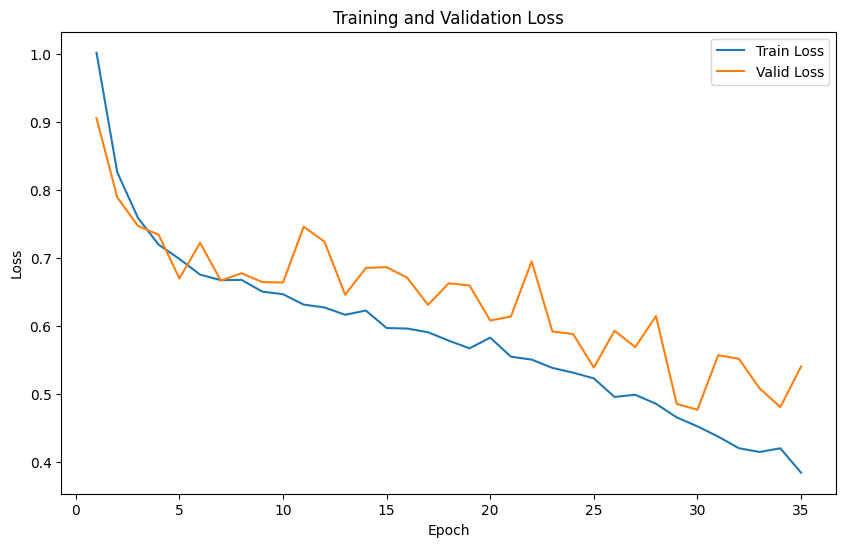

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses)+ 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Testing

In [ ]:
total_correct = 0
correct=0
total_samples = 0
sample=0

with torch.no_grad():
     for audios, labels in test_dataloader:

        audios = audios.to(device)
        labels = labels.to(device)
        audios=audios.reshape(8,1,224,224)
        outputs = model(audios)["logits"]
        threshold = 0.2
        preds = (outputs > threshold).float()
        preds=preds.cpu()

        for i in range(len(labels)):
          labels=labels.cpu()
          if np.argmax(preds[i] == np.argmax(labels[i])):
             correct = correct + 1
          sample=sample+1

          total_samples=sample

# Calculate test accuracy
test_accuracy = correct / sample

print(f'Total Correct Predictions: {correct}')
print(f'Total Samples: {total_samples}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Total Correct Predictions: 19
Total Samples: 24
Test Accuracy: 79.17%
